In [1]:
import pandas as pd
import dtale
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error,explained_variance_score
import glob
import dask.dataframe as dd
import xarray as xr
from scipy import stats
from sklearn.svm import SVR
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.inspection import plot_partial_dependence
from warnings import filterwarnings
filterwarnings('ignore')
import plotly
import plotly.graph_objs as go
import plotly.tools as tls
import seaborn as sns
import time
import plotly.express as px
import chart_studio.plotly as py
import folium
from folium.plugins import HeatMap
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot
init_notebook_mode(connected = True)
from folium.plugins import FastMarkerCluster

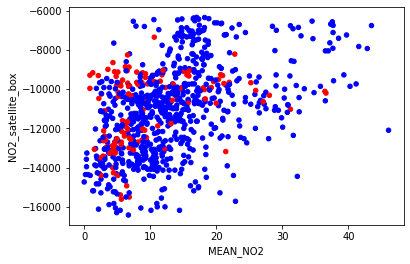

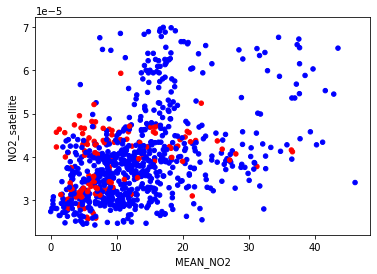

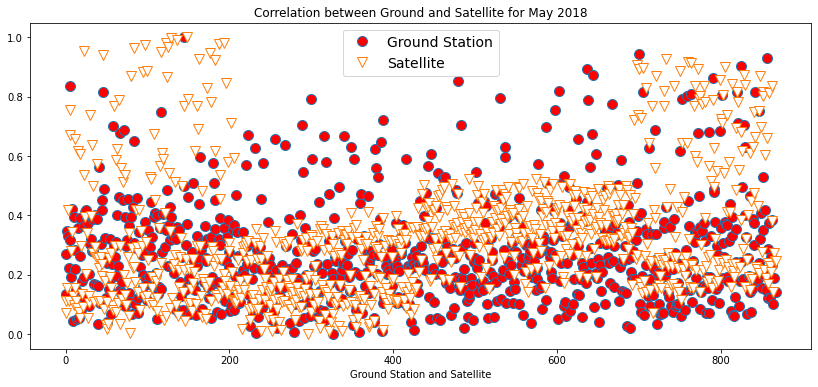

In [2]:
#Calculation for May 2018

df_May_2018= pd.read_csv('2018 May Grnd.csv')
df=df_May_2018

MEAN_NO2_may=df['MEAN_NO2'].values
NO2_satellite_may=df['NO2_satellite'].values

df['NO2_satellite_box'],_ = stats.boxcox(df['NO2_satellite'])
colors = np.where(df.COUNT > 300, 'r', 'b')
df.plot.scatter(x='MEAN_NO2',y='NO2_satellite_box', c=colors)
df.plot.scatter(x='MEAN_NO2',y='NO2_satellite', c=colors)

scaler=MinMaxScaler()
MEAN_NO2=df['MEAN_NO2'].values
MEAN_NO2=MEAN_NO2.reshape(-1,1)
MEAN_NO2=scaler.fit_transform(MEAN_NO2)


NO2_satellite=df['NO2_satellite'].values
NO2_satellite=NO2_satellite.reshape(-1,1)
NO2_satellite=scaler.fit_transform(NO2_satellite)



df['MEAN_NO2_T']= pd.DataFrame(MEAN_NO2)
df['NO2_satellite_T']= pd.DataFrame(NO2_satellite)

#df.corr()['MEAN_NO2_T'].sort_values().plot(kind='bar')

fig = plt.figure(figsize=(14,6))
plt.plot(MEAN_NO2,marker="o", ms = 10, mfc = 'r', linestyle='None',label='Ground Station')
plt.plot(NO2_satellite,marker="v", ms = 10,linestyle='None', mfc = 'w',label='Satellite')
plt.title('Correlation between Ground and Satellite for May 2018')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Ground Station and Satellite')



corr=df.corr()['MEAN_NO2'].sort_values()

corr=list(corr)

grnd_corr_may=corr[2]



In [3]:
dtale.show(df)

In [4]:
out_index=np.where(df['MEAN_NO2']>30)
df= df.drop(out_index[0])

In [5]:
dtale.show(df)

In [6]:
df= df.drop(df.tail(17).index)

In [7]:
dtale.show(df)

In [8]:
#Reading CAMs Data for May 2018
no2_may = xr.open_dataset("CAMS_2018_May_12.00_Surface.nc", engine="netcdf4")
no2_may

<xarray.Dataset>
Dimensions:    (latitude: 1441, longitude: 2880, time: 31)
Coordinates:
  * longitude  (longitude) float32 0.0 0.125 0.25 0.375 ... 359.6 359.8 359.9
  * latitude   (latitude) float32 90.0 89.88 89.75 89.62 ... -89.75 -89.88 -90.0
  * time       (time) datetime64[ns] 2018-05-01T12:00:00 ... 2018-05-31T12:00:00
Data variables:
    tcno2      (time, latitude, longitude) float32 ...
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
    t2m        (time, latitude, longitude) float32 ...
    lsp        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-05-21 23:32:19 GMT by grib_to_netcdf-2.21.0: grib_to_n...

In [9]:
#Extracting Each Variables 
tno2_may=no2_may.tcno2
u10_may=no2_may.u10
v10_may=no2_may.v10
t2m_may=no2_may.t2m
lsp_may=no2_may.lsp

In [42]:
lsp_may

<xarray.DataArray 'lsp' (time: 31, latitude: 1441, longitude: 2880)>
array([[[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]],

       [[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]],

       ...,

       [[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]],

       [[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 0.0 0.125 0.25 0.375 ... 359.6 359.8 359.9
  * latitude   (latitude) float32 90.0 89.88 89.75 89.62 ... -89.75 -89.88 -90.0
  * time       (time) datetime64[ns] 2018-05-01T12:00:00 ... 2018-05-31T12:00:00
Attributes:
    units:          m
    long_name:      Large-scale precipitation
    standard_name:  lwe_thickness_of_stratiform_precipitation_amount

In [11]:
#Finding the index for particular Lat and Lon
lat_ind= np.where(tno2_may.latitude.data==38) 
lon_ind= np.where(tno2_may.longitude.data==58)
lat_ind=int(lat_ind[0])
lon_ind=int(lon_ind[0])
print(no2_may.longitude.data[lon_ind:lon_ind+14])
print(tno2_may.latitude.data[lat_ind:lat_ind+14])

[58.    58.125 58.25  58.375 58.5   58.625 58.75  58.875 59.    59.125
 59.25  59.375 59.5   59.625]
[38.    37.875 37.75  37.625 37.5   37.375 37.25  37.125 37.    36.875
 36.75  36.625 36.5   36.375]


In [12]:
#Extracting No2 for the bay area for The Month of May
cams_no2=[]
for i in range(31):
   cams_no2_1=list(tno2_may.data[i,lon_ind:lon_ind+13,58])
   cams_no2_2=list(tno2_may.data[i,37,lat_ind:lat_ind+13])
   cams_no2=cams_no2+cams_no2_1+cams_no2_2
   #print(cams_no2)

In [13]:
#Extracting u10 (10 metre U wind component) for the bay area for The Month of May
cams_u10=[]
for i in range(31):
   cams_u10_1=list(u10_may.data[i,lon_ind:lon_ind+13,58])
   cams_u10_2=list(u10_may.data[i,37,lat_ind:lat_ind+13])
   cams_u10=cams_u10+cams_u10_1+cams_u10_2

In [14]:
#Extracting v10 (10 metre V wind component) for the bay area for The Month of May
cams_v10=[]
for i in range(31):
   cams_v10_1=list(v10_may.data[i,lon_ind:lon_ind+13,58])
   cams_v10_2=list(v10_may.data[i,37,lat_ind:lat_ind+13])
   cams_v10=cams_v10+cams_v10_1+cams_v10_2


In [15]:
#Extracting t2m (2 metre temperature) for the bay area for The Month of May
cams_t2m=[]
for i in range(31):
   cams_t2m_1=list(t2m_may.data[i,lon_ind:lon_ind+13,58])
   cams_t2m_2=list(t2m_may.data[i,37,lat_ind:lat_ind+13])
   cams_t2m=cams_t2m+cams_t2m_1+cams_t2m_2


In [16]:
#Extracting lsp (Large-scale precipitation) for the bay area for The Month of May
cams_lsp=[]
for i in range(31):
   cams_lsp_1=list(lsp_may.data[i,lon_ind:lon_ind+13,58])
   cams_lsp_2=list(lsp_may.data[i,37,lat_ind:lat_ind+13])
   cams_lsp=cams_lsp+cams_lsp_1+cams_lsp_2

In [17]:
df['cams_no2']=cams_no2
df['cams_u10']=cams_u10
df['cams_v10']=cams_v10
df['cams_t2m']=cams_t2m
df['cams_t2m']=cams_lsp

In [18]:
df=df.drop(['COUNT','MEAN_NO2_T','NO2_satellite_T','NO2_satellite_box'],axis=1)

In [19]:
dtale.show(df)

In [20]:
X=df.drop('MEAN_NO2',axis=1).values
y=df['MEAN_NO2'].values

In [21]:
model_params = {
    'svm': {
        'model': SVR(gamma='auto'),
        'params' : {
            'C': [10,20,50],
            'kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestRegressor(),
        'params' : {
            'n_estimators': [5,10,15]
        }
    },
}

In [22]:
scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(X, y)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
df_score = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df_score

,model,best_score,best_params
0,svm,0.208724,"{'C': 50, 'kernel': 'linear'}"
1,random_forest,0.357265,{'n_estimators': 15}


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [24]:
model = SVR(kernel='linear', C=10, gamma='auto', degree=2, epsilon=.1,
               coef0=1)
model.fit(X_train,y_train)

SVR(C=10, coef0=1, degree=2, gamma='auto', kernel='linear')

In [25]:
prediction=model.predict(X_test)
MSE=mean_squared_error(y_test,prediction)
print("Mean Squared Error =",MSE)

Mean Squared Error = 26.934293939028887


In [26]:
RMSE=mean_squared_error(y_test,prediction, squared=False)
print("Root Mean Square Error =",RMSE)

Root Mean Square Error = 5.18982600277012


Text(0, 0.5, 'No2 (mol/m2)')

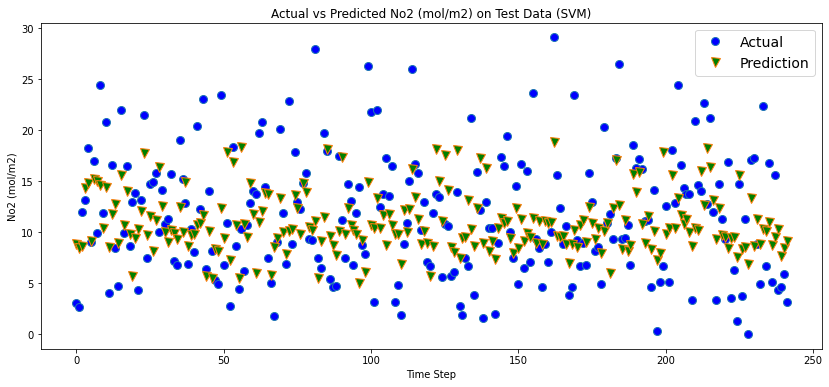

In [27]:
fig = plt.figure(figsize=(14,6))
plt.plot(y_test,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted No2 (mol/m2) on Test Data (SVM)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Time Step')
plt.ylabel('No2 (mol/m2)')

In [28]:
all_prediction=model.predict(X)

In [29]:
Mean_no2=df['MEAN_NO2']

Text(0, 0.5, 'No2 (mol/m2)')

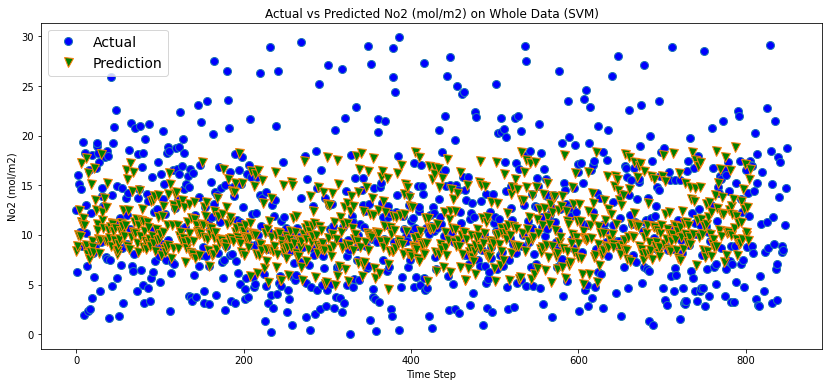

In [30]:
fig = plt.figure(figsize=(14,6))
plt.plot(Mean_no2,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(all_prediction,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted No2 (mol/m2) on Whole Data (SVM)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Time Step')
plt.ylabel('No2 (mol/m2)')


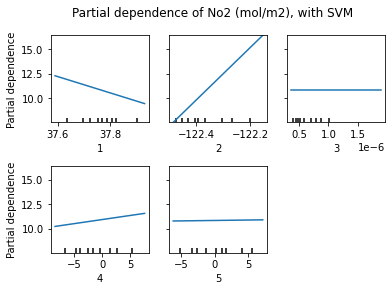

In [31]:
display = plot_partial_dependence(
       model, X, features=[1,2,3,4,5])

display.figure_.suptitle('Partial dependence of No2 (mol/m2), with SVM')
display.figure_.subplots_adjust(hspace=0.5)

[58.    58.125 58.25  58.375 58.5   58.625 58.75  58.875 59.    59.125
 59.25  59.375 59.5   59.625]
[38.    37.875 37.75  37.625 37.5   37.375 37.25  37.125 37.    36.875
 36.75  36.625 36.5   36.375]
Mean Squared Error = 37.918193893114264
Root Mean Square Error = 6.157775076528393


Text(0, 0.5, 'No2 (mol/m2)')

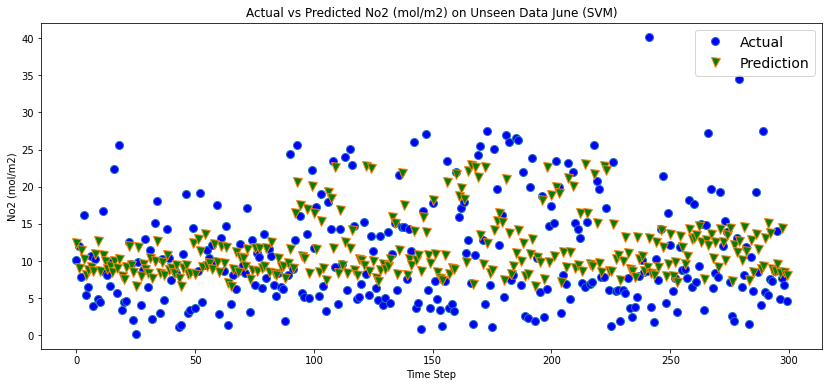

In [32]:
#Calculation for Unseen data
df_june_2018= pd.read_csv('2018 June Grnd.csv')


#Reading CAMs Data for June 2018
no2_june = xr.open_dataset("CAMS_2018_June_12.00_Surface.nc", engine="netcdf4")
no2_june



#Extracting Each Variables 
tno2_june=no2_june.tcno2
u10_june=no2_june.u10
v10_june=no2_june.v10
t2m_june=no2_june.t2m
lsp_june=no2_june.lsp



#Finding the index for particular Lat and Lon
lat_ind= np.where(tno2_june.latitude.data==38) 
lon_ind= np.where(tno2_june.longitude.data==58)
lat_ind=int(lat_ind[0])
lon_ind=int(lon_ind[0])
print(no2_june.longitude.data[lon_ind:lon_ind+14])
print(tno2_june.latitude.data[lat_ind:lat_ind+14])

#Extracting No2 for the bay area for The Month of june
cams_no2=[]
for i in range(30):
   cams_no2_1=list(tno2_june.data[i,lon_ind:lon_ind+5,58])
   cams_no2_2=list(tno2_june.data[i,37,lat_ind:lat_ind+5])
   cams_no2=cams_no2+cams_no2_1+cams_no2_2
   #print(cams_no2)

#Extracting u10 (10 metre U wind component) for the bay area for The Month of june
cams_u10=[]
for i in range(30):
   cams_u10_1=list(u10_june.data[i,lon_ind:lon_ind+5,58])
   cams_u10_2=list(u10_june.data[i,37,lat_ind:lat_ind+5])
   cams_u10=cams_u10+cams_u10_1+cams_u10_2

#Extracting v10 (10 metre V wind component) for the bay area for The Month of june
cams_v10=[]
for i in range(30):
   cams_v10_1=list(v10_june.data[i,lon_ind:lon_ind+5,58])
   cams_v10_2=list(v10_june.data[i,37,lat_ind:lat_ind+5])
   cams_v10=cams_v10+cams_v10_1+cams_v10_2

#Extracting t2m (2 metre temperature) for the bay area for The Month of june
cams_t2m=[]
for i in range(30):
   cams_t2m_1=list(t2m_june.data[i,lon_ind:lon_ind+5,58])
   cams_t2m_2=list(t2m_june.data[i,37,lat_ind:lat_ind+5])
   cams_t2m=cams_t2m+cams_t2m_1+cams_t2m_2

#Extracting lsp (Large-scale precipitation) for the bay area for The Month of june
cams_lsp=[]
for i in range(30):
   cams_lsp_1=list(lsp_june.data[i,lon_ind:lon_ind+5,58])
   cams_lsp_2=list(lsp_june.data[i,37,lat_ind:lat_ind+5])
   cams_lsp=cams_lsp+cams_lsp_1+cams_lsp_2


df_june_2018['cams_no2']=cams_no2
df_june_2018['cams_u10']=cams_u10
df_june_2018['cams_v10']=cams_v10
df_june_2018['cams_t2m']=cams_t2m
df_june_2018['cams_t2m']=cams_lsp


df_june_2018=df_june_2018.drop(['COUNT'],axis=1)


X_june=df_june_2018.drop('MEAN_NO2',axis=1).values
y_june=df_june_2018['MEAN_NO2'].values


prediction=model.predict(X_june)
MSE=mean_squared_error(y_june,prediction)
print("Mean Squared Error =",MSE)



RMSE=mean_squared_error(y_june,prediction, squared=False)
print("Root Mean Square Error =",RMSE)


fig = plt.figure(figsize=(14,6))
plt.plot(y_june,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted No2 (mol/m2) on Unseen Data June (SVM)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Time Step')
plt.ylabel('No2 (mol/m2)')


In [33]:
#Rainforest Regression
model = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
                          n_estimators=10)
model.fit(X_train,y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=4),
                  n_estimators=10)

In [34]:
prediction=model.predict(X_test)
MSE=mean_squared_error(y_test,prediction)
print("Mean Squared Error =",MSE)

Mean Squared Error = 22.17776522721965


In [35]:
RMSE=mean_squared_error(y_test,prediction, squared=False)
print("Root Mean Square Error =",RMSE)

Root Mean Square Error = 4.709327470798739


Text(0, 0.5, 'No2 (mol/m2)')

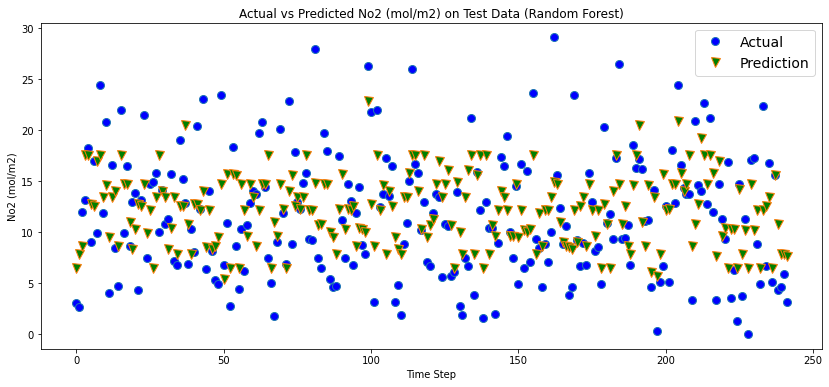

In [36]:

fig = plt.figure(figsize=(14,6))
plt.plot(y_test,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted No2 (mol/m2) on Test Data (Random Forest)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Time Step')
plt.ylabel('No2 (mol/m2)')


In [37]:
all_prediction=model.predict(X)

Text(0, 0.5, 'No2 (mol/m2)')

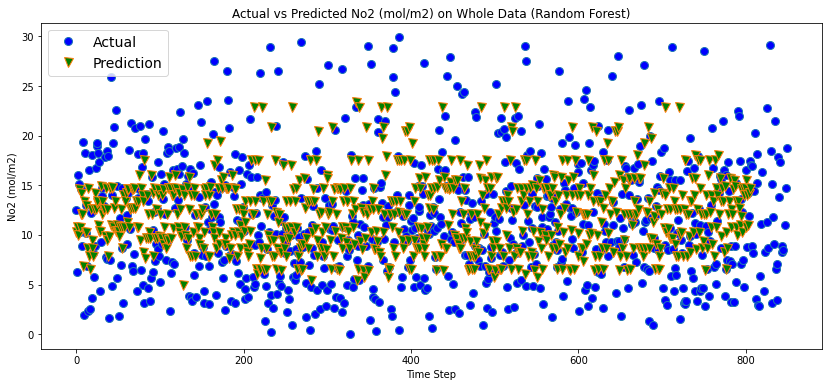

In [38]:
fig = plt.figure(figsize=(14,6))
plt.plot(Mean_no2,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(all_prediction,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted No2 (mol/m2) on Whole Data (Random Forest)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Time Step')
plt.ylabel('No2 (mol/m2)')


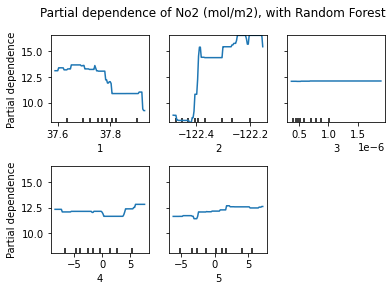

In [39]:
display = plot_partial_dependence(
       model, X, features=[1,2,3,4,5])

display.figure_.suptitle('Partial dependence of No2 (mol/m2), with Random Forest')
display.figure_.subplots_adjust(hspace=0.5)

[58.    58.125 58.25  58.375 58.5   58.625 58.75  58.875 59.    59.125
 59.25  59.375 59.5   59.625]
[38.    37.875 37.75  37.625 37.5   37.375 37.25  37.125 37.    36.875
 36.75  36.625 36.5   36.375]
Mean Squared Error = 41.24273218687099
Root Mean Square Error = 6.422050465923713


Text(0, 0.5, 'No2 (mol/m2)')

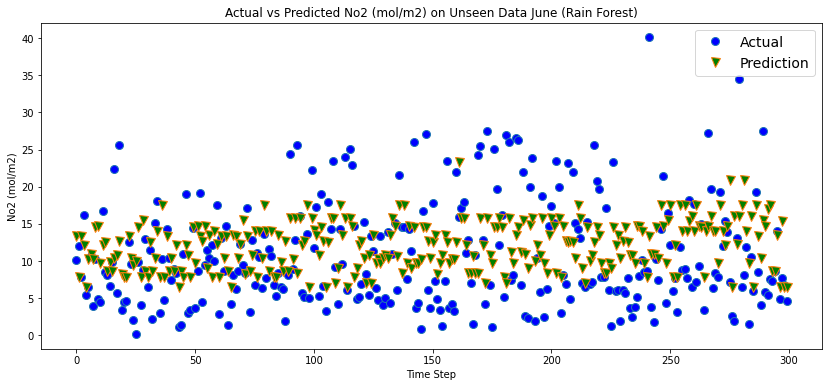

In [40]:
#Calculation for Unseen data
df_june_2018= pd.read_csv('2018 June Grnd.csv')


#Reading CAMs Data for June 2018
no2_june = xr.open_dataset("CAMS_2018_June_12.00_Surface.nc", engine="netcdf4")
no2_june


# In[106]:


#Extracting Each Variables 
tno2_june=no2_june.tcno2
u10_june=no2_june.u10
v10_june=no2_june.v10
t2m_june=no2_june.t2m
lsp_june=no2_june.lsp


# In[107]:


u10_june.data.shape


# In[108]:


#Finding the index for particular Lat and Lon
lat_ind= np.where(tno2_june.latitude.data==38) 
lon_ind= np.where(tno2_june.longitude.data==58)
lat_ind=int(lat_ind[0])
lon_ind=int(lon_ind[0])
print(no2_june.longitude.data[lon_ind:lon_ind+14])
print(tno2_june.latitude.data[lat_ind:lat_ind+14])

#Extracting No2 for the bay area for The Month of june
cams_no2=[]
for i in range(30):
   cams_no2_1=list(tno2_june.data[i,lon_ind:lon_ind+5,58])
   cams_no2_2=list(tno2_june.data[i,37,lat_ind:lat_ind+5])
   cams_no2=cams_no2+cams_no2_1+cams_no2_2
   #print(cams_no2)

#Extracting u10 (10 metre U wind component) for the bay area for The Month of june
cams_u10=[]
for i in range(30):
   cams_u10_1=list(u10_june.data[i,lon_ind:lon_ind+5,58])
   cams_u10_2=list(u10_june.data[i,37,lat_ind:lat_ind+5])
   cams_u10=cams_u10+cams_u10_1+cams_u10_2

#Extracting v10 (10 metre V wind component) for the bay area for The Month of june
cams_v10=[]
for i in range(30):
   cams_v10_1=list(v10_june.data[i,lon_ind:lon_ind+5,58])
   cams_v10_2=list(v10_june.data[i,37,lat_ind:lat_ind+5])
   cams_v10=cams_v10+cams_v10_1+cams_v10_2

#Extracting t2m (2 metre temperature) for the bay area for The Month of june
cams_t2m=[]
for i in range(30):
   cams_t2m_1=list(t2m_june.data[i,lon_ind:lon_ind+5,58])
   cams_t2m_2=list(t2m_june.data[i,37,lat_ind:lat_ind+5])
   cams_t2m=cams_t2m+cams_t2m_1+cams_t2m_2

#Extracting lsp (Large-scale precipitation) for the bay area for The Month of june
cams_lsp=[]
for i in range(30):
   cams_lsp_1=list(lsp_june.data[i,lon_ind:lon_ind+5,58])
   cams_lsp_2=list(lsp_june.data[i,37,lat_ind:lat_ind+5])
   cams_lsp=cams_lsp+cams_lsp_1+cams_lsp_2


df_june_2018['cams_no2']=cams_no2
df_june_2018['cams_u10']=cams_u10
df_june_2018['cams_v10']=cams_v10
df_june_2018['cams_t2m']=cams_t2m
df_june_2018['cams_t2m']=cams_lsp


df_june_2018=df_june_2018.drop(['COUNT'],axis=1)


X_june=df_june_2018.drop('MEAN_NO2',axis=1).values
y_june=df_june_2018['MEAN_NO2'].values


prediction=model.predict(X_june)
MSE=mean_squared_error(y_june,prediction)
print("Mean Squared Error =",MSE)


# In[126]:


RMSE=mean_squared_error(y_june,prediction, squared=False)
print("Root Mean Square Error =",RMSE)


fig = plt.figure(figsize=(14,6))
plt.plot(y_june,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted No2 (mol/m2) on Unseen Data June (Rain Forest)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Time Step')
plt.ylabel('No2 (mol/m2)')
